In [296]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

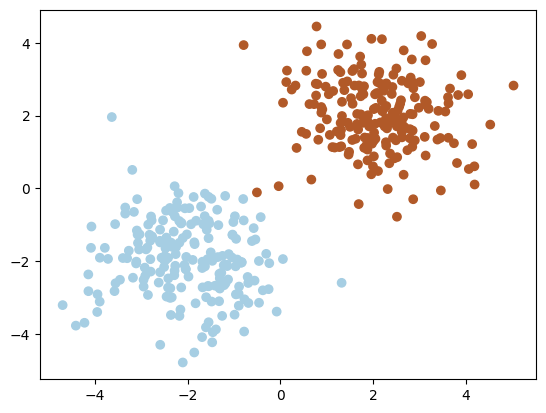

In [297]:
# 数据准备
NUM = 200
np.random.seed(1)
x1 = np.random.randn(NUM,2)+[2,2]
x2 = np.random.randn(NUM,2)-[2,2]
X = np.concatenate((x1,x2),axis=0)
y = np.concatenate((np.ones(NUM),-np.ones(NUM)),axis=0)
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.Paired)
ax = plt.gca()

C = 1 # 惩罚系数
tol = 0.001 # 容忍度
max_iter = 1000 # 最大迭代次数
m,n = X.shape # m个样本，n个特征
alpha = np.zeros(m) # 初始化拉格朗日乘子
b = 0 # 初始化截距
iters = 0 # 初始化迭代数


In [298]:
def kernel(x,y,type='linear'):
    if type == 'linear':
        result = np.dot(x,y)
    return result

def f_i(num,alpha,b):
    result = np.dot(alpha*y,kernel(X,X[num]))+b
    return result

def Error(num,alpha,b):
    result = f_i(num,alpha,b)-y[num]
    return result

def KKT_error_distance(num,alpha,b):
    if alpha[num] == 0:
        delta = y[num]*f_i(num,alpha,b) - 1
        if delta < 0:
            return abs(delta)
        else:
            return 0
    elif alpha[num] > 0 and alpha[num] < C:
        delta = y[num]*f_i(num,alpha,b) - 1
        if delta == 0:
            return 0
        else:
            return abs(delta)
    elif alpha[num] == C:
        delta = y[num]*f_i(num,alpha,b) - 1
        if delta > 0:
            return abs(delta)
        else:
            return 0
        
def KKT_error(X,alpha,b,type='max'):
    result = []
    for i in range(np.shape(X)[0]):
        result.append([KKT_error_distance(i,alpha,b),i])
    result = pd.DataFrame(result)
    if type == 'max':
        result = result.sort_values(by=[0,1])
        result = [result.iloc[-1].name,result.iloc[-1].values[0]]
        return result
    if type == 'list':
        return result

def E_choice(num,alpha,b,type='choice'):
    result = []
    for i in range(np.shape(X)[0]):
        result.append([Error(i,alpha,b),i])
    result = pd.DataFrame(result).sort_values(by=[0,1])
    E1 = Error(num,alpha,b)
    if type == 'choice':
        if E1 > 0:
            result = [result.iloc[0].name,result.iloc[0].values[0]]
        elif E1 < 0:
            result = [result.iloc[-1].name,result.iloc[-1].values[0]]
        else:
            result = abs(result).sort_values(by=[0,1])
            result = [result.iloc[-1].name,result.iloc[-1].values[0]]
        return result
    if type == 'list':
        return result

def choice_i_j(X,alpha,b):
    i = KKT_error(X,alpha,b)[0]
    j = E_choice(i,alpha,b)[0]
    return i,j

def eta(i,j):
    result = kernel(X[i],X[i]) + kernel(X[j],X[j]) - 2*kernel(X[i],X[j])
    return result

def cut_off(alpha_old,i,j,Ei_old,Ej_old):
    if y[i] != y[j]:
        L = max(0,alpha_old[j]-alpha_old[i])
        H = min(C,C+alpha_old[j]-alpha_old[i])
    else:
        L = max(0,alpha_old[j]+alpha_old[i]-C)
        H = min(C,alpha_old[j]+alpha_old[i])
    alpha_j = alpha_old[j] + y[j]*(Ei_old-Ej_old)/eta(i,j)
    alpha_j = min(alpha_j,H)
    alpha_j = max(alpha_j,L)
    return alpha_j

def inner_any(alpha_old,i,j):
    index = np.asarray([index for index, value in enumerate(alpha)])
    choice_index = index[(alpha < 1) & (alpha > 0)]
    for k in choice_index:
        if k == i:
            continue
        else:
            j = k
            result = cut_off(alpha_old,i,j,Error(i,alpha,b),Error(j,alpha,b))
            if abs(result - alpha_old[j]) < 0.0001:
                continue
            else:
                return (result,j)
    for k in index:
        j = np.random.choice(index)
        if j == i:
            continue
        else:
            result = cut_off(alpha_old,i,j,Error(i,alpha,b),Error(j,alpha,b))
            if abs(result - alpha_old[j]) < 0.0001:
                continue
            else:
                return (result,j)
    raise Exception('No suitable j is found')

In [299]:
def svm(X,y,C,b,alpha):
    i = choice_i_j(X,alpha,b)[0]
    j = choice_i_j(X,alpha,b)[1]
    alpha_old_j = alpha[j]
    alpha_old_i = alpha[i]
    Ei = Error(i,alpha,b)
    Ej = Error(j,alpha,b)

    while True:
        j = np.random.choice([k for k in range(X.shape[0]) if k != i])
        if eta(i,j) == 0:
            continue
        elif abs(cut_off(alpha,i,j,Ei,Ej)-alpha_old_j) > 0.0001:
            break
    temp_j = cut_off(alpha,i,j,Error(i,alpha,b),Error(j,alpha,b))
    alpha[j] = temp_j
    temp_i = alpha_old_i + y[i]*y[j]*(alpha_old_j-alpha[j])
    alpha[i] = temp_i

    b1 = b - Ei - y[i]*kernel(X[i],X[i])*(alpha[i]-alpha_old_i) - y[j]*kernel(X[j],X[i])*(alpha[j]-alpha_old_j)
    b2 = b - Ej - y[i]*kernel(X[i],X[j])*(alpha[i]-alpha_old_i) - y[j]*kernel(X[j],X[j])*(alpha[j]-alpha_old_j)

    if 0 < alpha[i] < C and 0 < alpha[j] < C:
        b = b1
    else:
        b = (b1+b2)/2

    KKT = KKT_error(X,alpha,b,type='list')

    w = np.dot(alpha*y,X)

    return i,j,KKT,b,w,alpha

In [300]:
for i in range(1000):
    I,J,KKT,b,w,alpha = svm(X,y,C,b,alpha)

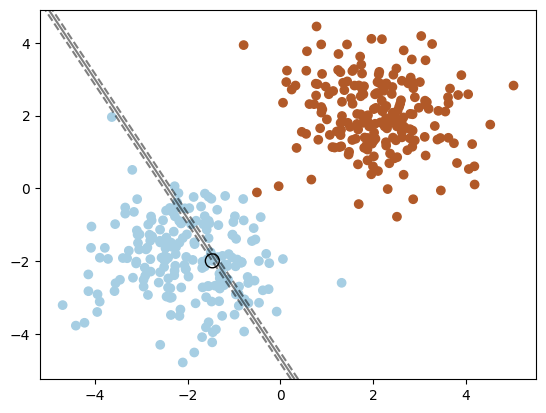

In [301]:
# 绘制数据集和决策边界
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# 生成网格点并预测分类
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = np.dot(xy, w.T) + b

# 绘制决策边界和支持向量
Z = Z.reshape(XX.shape)
plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
plt.scatter(X[np.where(np.abs(np.dot(X, w.T) + b - 1) < 0.1)[0], 0],
            X[np.where(np.abs(np.dot(X, w.T) + b - 1) < 0.1)[0], 1],
            marker='o', s=100, edgecolors='k', facecolors='none')
plt.scatter(X[np.where(np.abs(np.dot(X, w.T) + b + 1) < 0.1)[0], 0],
            X[np.where(np.abs(np.dot(X, w.T) + b + 1) < 0.1)[0], 1],
            marker='o', s=100, edgecolors='k', facecolors='none')